<h1>Chapter 4 | Data Exercise #3 | <code>wms-management-survey</code> | Comparison and correlation</h1>
<h2>Introduction:</h2>
<p>In this notebook, you will find my notes and code for Chapter 5's <b>exercise 3</b> of the book <a href="https://gabors-data-analysis.com/">Data Analysis for Business, Economics, and Policy</a>, by Gábor Békés and Gábor Kézdi. The question was: 
<p>2. Using the <code>wms-management-survey</code> dataset:</p>
<p>Assignments:</p>
<ul>
    <li>Pick a country of your choice.</li>
    <li>Create a management score from a meaningful subset of the 18 items (e.g. managing talent).</li>
    <li>Carry out an analysis to uncover the patterns of association with employment.</li>
    <li>Summarize what you find and comment on which visualization you find the most useful.</li>
</ul>
<h2><b>1.</b> Load the data</h2>

In [434]:
import os
import sys
import warnings
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from plotnine import *
from mizani.formatters import percent_format

warnings.filterwarnings("ignore")
%matplotlib inline

In [435]:
# Increase number of returned rows in pandas
pd.set_option("display.max_rows", 500)

In [436]:
# Current script folder
current_path = os.getcwd()
dirname = current_path.split("da_data_exercises")[0]

# Get location folders
data_in = f"{dirname}da_data_repo/wms-management-survey/clean/"
data_out = f"{dirname}da_data_exercises/ch04-comparison_correlation/03-wms_management_ex2/data/clean/"
output = f"{dirname}da_data_exercises/ch04-comparison_correlation/03-wms_management_ex2/"
func = f"{dirname}da_case_studies/ch00-tech_prep/"
sys.path.append(func)

In [437]:
from py_helper_functions import *

In [438]:
df = pd.read_csv(f"{data_in}wms_da_textbook.csv", usecols=[*range(0, 32)]) # exclude logical variables that won't be used in this exercise

In [439]:
df["country"].unique()

array(['United States', 'India', 'New Zealand', 'Australia', 'Argentina',
       'Brazil', 'Canada', 'Chile', 'China', 'Germany', 'Spain', 'France',
       'Northern Ireland', 'Great Britain', 'Greece',
       'Republic of Ireland', 'Italy', 'Japan', 'Mexico', 'Poland',
       'Portugal', 'Sweden', 'Singapore', 'Turkey'], dtype=object)

In [440]:
df_2014 = df.loc[df["wave"] == 2014]
df_2014["country"].value_counts()

country
Italy            318
Greece           313
Great Britain    296
United States    217
France           141
Portugal          99
Germany           77
Name: count, dtype: int64

<h3>1.1 Sample selection</h3>
<p>Let's pick a country with different proportions than Mexico yet let's apply the same exclusions made by the author, that is, filtering out firms with fewer than 100 employees and more than 5000 employees. We will pick a different year and a country with a possibly different industry structure - let's pick <b>Italy</b>.</p>

In [441]:
df = df.loc[
    lambda x: (x["country"] == "Italy") &
              (x["wave"] == 2014) &
              (x["emp_firm"] >= 100) &
              (x["emp_firm"] <= 5000)
]

In [442]:
df["emp_firm"].describe()

count     281.000000
mean      537.131673
std       818.237523
min       100.000000
25%       150.000000
50%       240.000000
75%       500.000000
max      4800.000000
Name: emp_firm, dtype: float64

In [443]:
df.head()

,firmid,wave,cty,country,sic,management,operations,monitor,target,people,...,talent1,talent2,talent3,talent4,talent5,talent6,emp_firm,firmage,ownership,mne_yn
10051,7214,2014,it,Italy,25.0,3.111111,2.5,3.6,3.2,2.833333,...,3.0,2.0,4.0,3.0,2.0,3.0,320.0,52.0,Private Equity/Venture Capital,0.0
10055,7217,2014,it,Italy,30.0,2.777778,3.0,3.0,2.6,2.666667,...,3.0,3.0,3.0,2.0,3.0,2.0,140.0,5.0,Dispersed Shareholders,1.0
10057,7219,2014,it,Italy,34.0,3.222222,4.0,4.4,2.6,2.500000,...,2.0,1.0,2.0,3.0,3.0,4.0,290.0,60.0,Private Individuals,1.0
10059,7220,2014,it,Italy,36.0,4.388889,4.5,5.0,4.0,4.166667,...,4.0,3.0,5.0,4.0,5.0,4.0,3000.0,44.0,"Family owned, external CEO",1.0
10062,7221,2014,it,Italy,24.0,2.000000,2.0,2.0,1.6,2.333333,...,1.0,2.0,3.0,3.0,2.0,3.0,120.0,38.0,"Founder owned, founder CEO",0.0


<h2>2. Create a management score from a meaningful subset of the 18 items (e.g. managing talent).</h2>
<p>Let's explore the 18 items available on our dataset.</p>

In [444]:
df.columns

Index(['firmid', 'wave', 'cty', 'country', 'sic', 'management', 'operations',
       'monitor', 'target', 'people', 'lean1', 'lean2', 'perf1', 'perf2',
       'perf3', 'perf4', 'perf5', 'perf6', 'perf7', 'perf8', 'perf9', 'perf10',
       'talent1', 'talent2', 'talent3', 'talent4', 'talent5', 'talent6',
       'emp_firm', 'firmage', 'ownership', 'mne_yn'],
      dtype='object')

In [445]:
df.select_dtypes(include="number").head()

,firmid,wave,sic,management,operations,monitor,target,people,lean1,lean2,...,perf10,talent1,talent2,talent3,talent4,talent5,talent6,emp_firm,firmage,mne_yn
10051,7214,2014,25.0,3.111111,2.5,3.6,3.2,2.833333,2.0,3.0,...,2.0,3.0,2.0,4.0,3.0,2.0,3.0,320.0,52.0,0.0
10055,7217,2014,30.0,2.777778,3.0,3.0,2.6,2.666667,3.0,3.0,...,3.0,3.0,3.0,3.0,2.0,3.0,2.0,140.0,5.0,1.0
10057,7219,2014,34.0,3.222222,4.0,4.4,2.6,2.500000,5.0,3.0,...,3.0,2.0,1.0,2.0,3.0,3.0,4.0,290.0,60.0,1.0
10059,7220,2014,36.0,4.388889,4.5,5.0,4.0,4.166667,5.0,4.0,...,4.0,4.0,3.0,5.0,4.0,5.0,4.0,3000.0,44.0,1.0
10062,7221,2014,24.0,2.000000,2.0,2.0,1.6,2.333333,2.0,2.0,...,2.0,1.0,2.0,3.0,3.0,2.0,3.0,120.0,38.0,0.0


<p>It would be interesting to observe the correlation between firm size and performance indicators. Are larger firms more performatic than smaller ones? Let's find out.</p>
<p>Let's create a <code>peformance</code> score by taking the average score of all 10 performance indicators.</p>

In [446]:
df["performance"] = df.filter(like="perf").mean(axis=1)

In [447]:
df.filter(like="perf").head()

,perf1,perf2,perf3,perf4,perf5,perf6,perf7,perf8,perf9,perf10,performance
10051,4.0,3.0,4.0,3.0,4.0,3.0,3.0,4.0,4.0,2.0,3.4
10055,2.0,4.0,3.0,4.0,2.0,3.0,3.0,3.0,1.0,3.0,2.8
10057,4.0,5.0,4.0,5.0,4.0,2.0,2.0,3.0,3.0,3.0,3.5
10059,5.0,5.0,5.0,5.0,5.0,4.0,3.0,5.0,4.0,4.0,4.5
10062,2.0,2.0,3.0,1.0,2.0,2.0,2.0,1.0,1.0,2.0,1.8


<p>Great, we created our performance score out of 10 columns! Let's move on.</p>
<h2>3. Carry out an analysis to uncover the patterns of association with employment.</h2>
<h3>3.1 Visualizing the distribution of performance score</h3>
<p>Let's first explore the distribution of the performance score.</p>

In [448]:
df["performance"].describe()

count    281.000000
mean       3.134836
std        0.630996
min        1.400000
25%        2.700000
50%        3.100000
75%        3.500000
max        4.600000
Name: performance, dtype: float64

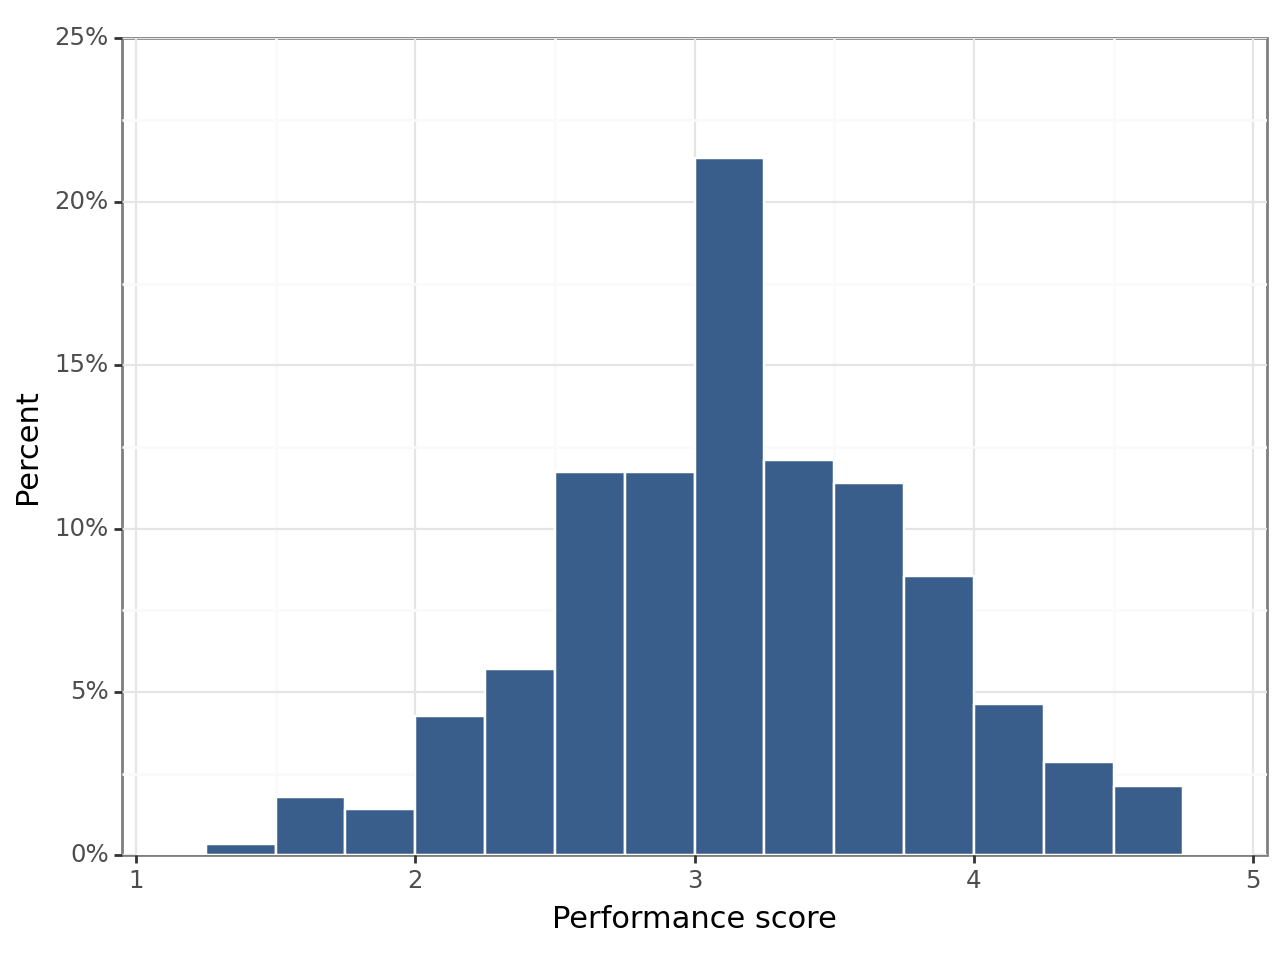

<Figure Size: (640 x 480)>

In [449]:
ggplot(df, aes(x="performance")) + geom_histogram(
    aes(y="stat(count)/sum(stat(count))"),
    fill=color[0],
    color="white",
    binwidth=0.25,
    boundary=0,
    closed="left",
) + labs(x="Performance score", y="Percent") + scale_x_continuous(
    expand=(0.01, 0.01), limits=(1, 5)
) + scale_y_continuous(
    expand=(0.00, 0.00),
    limits=(0, 0.25),
    breaks=seq(0, 0.26, by=0.05),
    labels=percent_format()
) + theme_bw()

Some observations about the histogram:
<ul>
<li>The mean is <b>3.13</b>, while the median is <b>3.1</b>. The dataset resembles a normal distribution, with a small degree of skewness to the left.</li>
<li>The standard deviation is <b>0.63</b>.</li>
<li>The mode is in the bin between <b>3</b> and <b>3.25</b>.
</ul>
<h3>3.2 Visualizing the distribution of employment</h3>
<p>We can start by looking at the summary statistics of Italian firms by their respective size, which is measured by the number of employees employed by each firm.</li>

In [450]:
df.loc[:, ["emp_firm"]].describe()

,emp_firm
count,281.000000
mean,537.131673
std,818.237523
min,100.000000
25%,150.000000
50%,240.000000
75%,500.000000
max,4800.000000


<p>Observations:</p>
<ul>
<li>The mean is <b>537</b> and the median, <b>240</b>.</li>
<li>The mean is far higher than the median and therefore we can expect a significant degree of <b>skewness</b> to the right.</li>
<li>The standard deviation is <b>818</b>.
</ul>

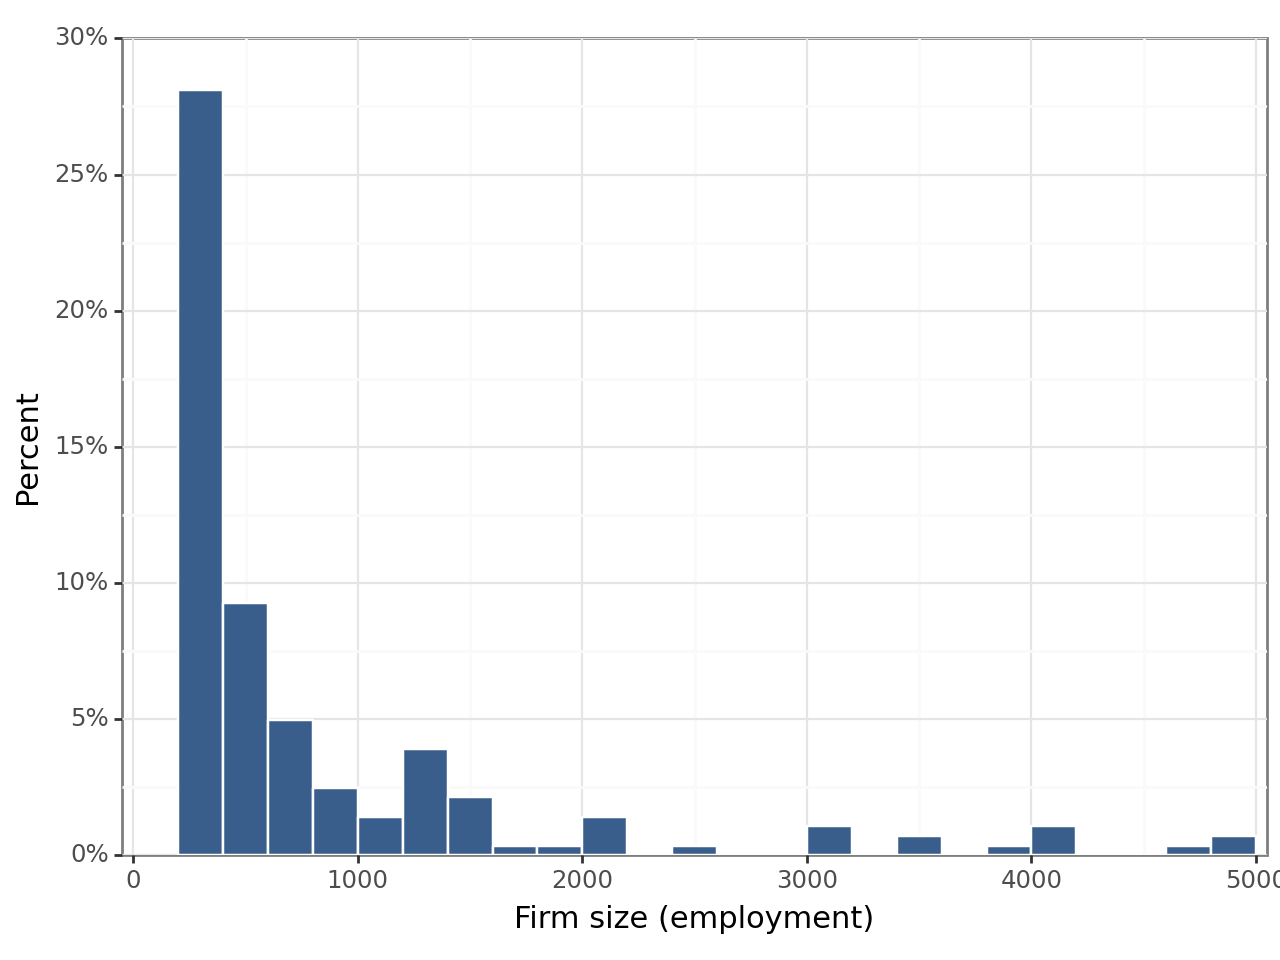

<Figure Size: (640 x 480)>

In [451]:
ggplot(df, aes(x="emp_firm", y="stat(count)/sum(stat(count))")) + geom_histogram(
    fill=color[0], color="white", binwidth=200, boundary=0, closed="left"
) + labs(x="Firm size (employment)", y="Percent") + scale_x_continuous(
    expand=(0.01, 0.01), limits=(0, 5000), breaks=seq(0, 5001, by=1000)
) + scale_y_continuous(
    expand=(0.00, 0.00),
    limits=(0, 0.3),
    breaks=seq(0, 0.5, by=0.05),
    labels=percent_format(),
) + theme_bw()

The histogram shows a high concentration of smaller firms in Italy. More specifically, more than 25% of all observations registered firms with less than 200 employees. Interestingly enough, there were no observations in the 200-400 bin.

To make this distribution more symmetric, we can plot a histogram formatted by the lognormal distribution.

In [452]:
df["lnemp_firm"] = np.log(df["emp_firm"])
df["lnemp_firm"].describe()

count    281.000000
mean       5.717706
std        0.930923
min        4.605170
25%        5.010635
50%        5.480639
75%        6.214608
max        8.476371
Name: lnemp_firm, dtype: float64

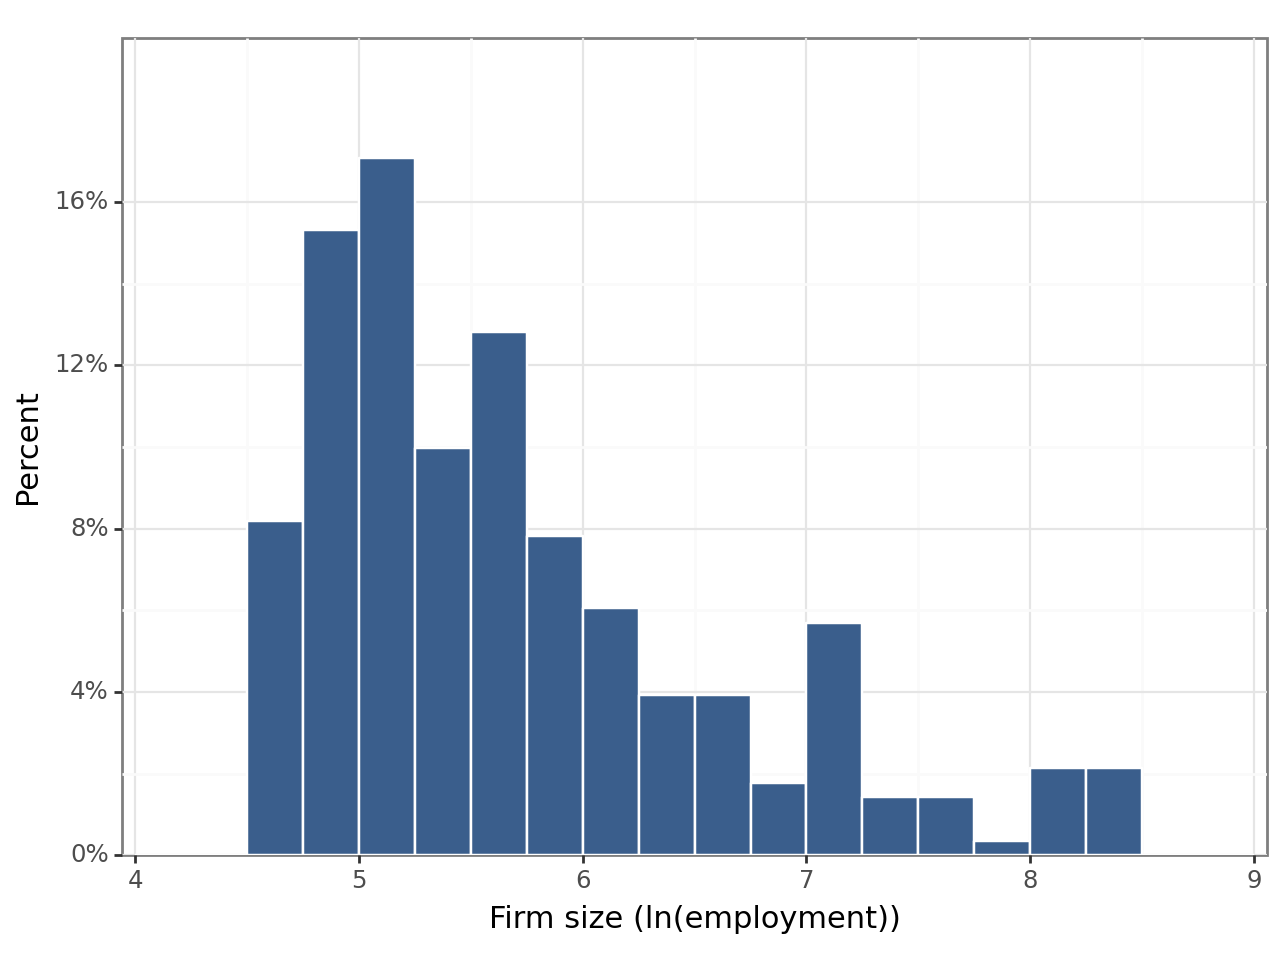

<Figure Size: (640 x 480)>

In [453]:
ggplot(df, aes(x="lnemp_firm"))  + geom_histogram(
    aes(y="stat(count)/sum(stat(count))"),
    fill=color[0], 
    color="white", 
    binwidth=0.25, 
    boundary=0, 
    closed="left"
) + labs(x="Firm size (ln(employment))", y="Percent") + scale_x_continuous(
    expand=(0.01, 0.01), limits=(4, 9) 
) + scale_y_continuous(
    expand=(0.00, 0.00),
    limits=(0, 0.2),
    breaks=seq(0, 0.2, by=0.04),
    labels=percent_format(),
) + theme_bw()

<p>We notice that the distribution is not as skewed as before, yet it still presents a longer tail to the right. The distribution, nonetheless, is much more symmetrical. In conclusion, the distribution of employment is skewed; while closer to lognormal than normal, the latter is still not the best approach.</p>
<h3>3.3 Conditional probabilities | Binning firm size</h3>
<p>As a reminder, <b>conditional probability</b> of an event means the probability of an event if another event (the conditioning event) happens. Because both the performance score and employment are quantitative variables with many values, they are not adequate for an investigation conditional probabilities.</p>
<p>To overcome this issue, we will create a <b>qualitative</b> variable by creating three bins of employment: <b>small, medium, and large</b>. Let's follow the book's example and bind the bins by three intervals: 100-199, 200-999, and 1000+.


In [454]:
df["emp3bins"] = np.where(df["emp_firm"] < 200, 1, np.nan)
df["emp3bins"] = np.where((df["emp_firm"] >= 200) & (df["emp_firm"] < 1000), 2, df["emp3bins"])
df["emp3bins"] = np.where(df["emp_firm"] >= 1000, 3, df["emp3bins"])

In [455]:
df.head()

,firmid,wave,cty,country,sic,management,operations,monitor,target,people,...,talent4,talent5,talent6,emp_firm,firmage,ownership,mne_yn,performance,lnemp_firm,emp3bins
10051,7214,2014,it,Italy,25.0,3.111111,2.5,3.6,3.2,2.833333,...,3.0,2.0,3.0,320.0,52.0,Private Equity/Venture Capital,0.0,3.4,5.768321,2.0
10055,7217,2014,it,Italy,30.0,2.777778,3.0,3.0,2.6,2.666667,...,2.0,3.0,2.0,140.0,5.0,Dispersed Shareholders,1.0,2.8,4.941642,1.0
10057,7219,2014,it,Italy,34.0,3.222222,4.0,4.4,2.6,2.500000,...,3.0,3.0,4.0,290.0,60.0,Private Individuals,1.0,3.5,5.669881,2.0
10059,7220,2014,it,Italy,36.0,4.388889,4.5,5.0,4.0,4.166667,...,4.0,5.0,4.0,3000.0,44.0,"Family owned, external CEO",1.0,4.5,8.006368,3.0
10062,7221,2014,it,Italy,24.0,2.000000,2.0,2.0,1.6,2.333333,...,3.0,2.0,3.0,120.0,38.0,"Founder owned, founder CEO",0.0,1.8,4.787492,1.0


In [456]:
df["emp3bins"].describe()

count    281.000000
mean       1.733096
std        0.694319
min        1.000000
25%        1.000000
50%        2.000000
75%        2.000000
max        3.000000
Name: emp3bins, dtype: float64

<p>We can make a few assumptions about the size of Italian firms by now.</p>
<ul>
<li>Italian firms tend to be medium-sized. The mean size is <b>1.73</b>, while the median is <b>2</b>.</li>
<li>The standard deviation is <b>0.69</b>, hence we can expect some variability in our dataset.</ul>
<li>As we already know, large firms in Italy tend to be a smaller fraction. We could see that in the distribution of the dataset, but considering the 25th percentile, we notice that a relevant portion of the companies are small to medium-sized.</li>
<h3>3.5 Plotting stacked charts - Describing patterns of association</h3>
<p>We will use stacked charts to visualize conditional probabilities. Because we have 15 conditional probabilities for each performance score (that is, the probability of each of the 5 values of y by each of the three values of x), a stacked bar chart will be of great assistance. Let's create the DataFrames for our job.</p>
<p>Let's choose two talent scores, `perf10` and `perf3`. The former measures "Clarity of Goals and Measurement", while the latter measures "Performance Review".

<h4>3.5.1 Stacked bar chart | (a) Clarity of Goals and Measurement</h4>

In [457]:
df1 = pd.DataFrame(
    df.loc[:, ["emp3bins", "perf10"]].groupby(["emp3bins", "perf10"]).agg("size")
).reset_index()

df1.columns = ["emp3bins", "perf10", "Count"]

group_counts = df1.groupby("emp3bins").agg("sum")["Count"]

df1.loc[df1["emp3bins"] == 1, "Percent"] = round(df1.loc[df1["emp3bins"] == 1, "Count"]/group_counts[1],5)
df1.loc[df1["emp3bins"] == 2, "Percent"] = round(df1.loc[df1["emp3bins"] == 2, "Count"]/group_counts[2],5)
df1.loc[df1["emp3bins"] == 3, "Percent"] = round(df1.loc[df1["emp3bins"] == 3, "Count"]/group_counts[3],5)

df1 = df1.assign(
    perf10=pd.Categorical(
        df1["perf10"], categories=sorted(set(df["perf10"]), reverse=True)
    )
)

In [458]:
df1

,emp3bins,perf10,Count,Percent
0,1.0,1.0,12,0.10435
1,1.0,2.0,55,0.47826
2,1.0,3.0,37,0.32174
3,1.0,4.0,10,0.08696
4,1.0,5.0,1,0.00870
5,2.0,1.0,11,0.08730
6,2.0,2.0,57,0.45238
7,2.0,3.0,43,0.34127
8,2.0,4.0,14,0.11111
9,2.0,5.0,1,0.00794


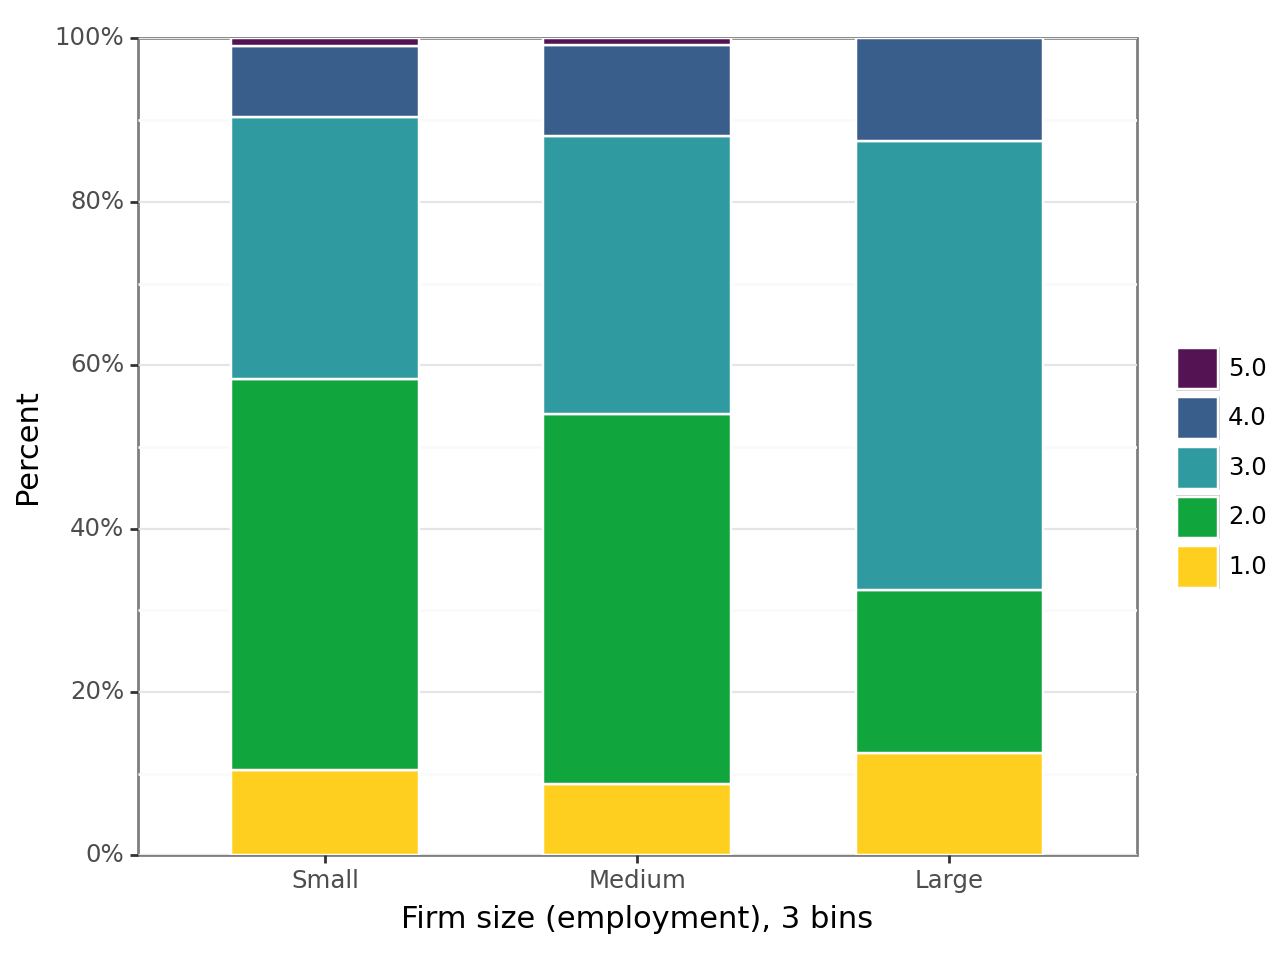

<Figure Size: (640 x 480)>

In [459]:
ggplot(df1, aes(x="emp3bins", y="Percent", fill="perf10")) + geom_bar(
    stat="identity", position="fill", width=0.6, color="white", size=0.5, alpha=0.8
) + scale_y_continuous( 
    expand=(0, 0), limits=(0, 1), breaks=seq(0, 1.1, by=0.2), labels=percent_format()
) + labs(
    x="Firm size (employment), 3 bins", y="Percent"
) + theme_bw() + theme(
    legend_position="right"
) + scale_fill_manual(
    values=(color[2], color[0], color[4], color[1], color[3]), name=" "
) + scale_x_discrete(limits=[1, 2, 3],
                     labels=["Small", "Medium", "Large"])

When it comes to defining goals, larger firms tend to perform betterin Italy. **Small firms**, on the on hand, scored 2 or less for almost 60% of observations. This proportion changed slightly for mid-sized firms. **Large firms**, on the other hand, showed a significant difference: 55% of firms scored 43 points, and 67% of them scored 3 or more. While the difference is significant, 3 is not that higher than 2. One must also notice that, among the three categories for firm sizes, scores of 4 or more did not change significantly.

<h4>3.5.2 Stacked bar chart | (b) Performance Review</h4>

In [460]:
df2 = pd.DataFrame(
    df.loc[:, ["emp3bins", "perf3"]].groupby(["emp3bins", "perf3"]).agg("size")
).reset_index()

df2.columns = ["emp3bins", "perf3", "Count"]

group_counts = df2.groupby("emp3bins").agg("sum")["Count"]

df2.loc[df2["emp3bins"] == 1, "Percent"] = round(df2.loc[df2["emp3bins"] == 1, "Count"]/group_counts[1],5)
df2.loc[df2["emp3bins"] == 2, "Percent"] = round(df2.loc[df2["emp3bins"] == 2, "Count"]/group_counts[2],5)
df2.loc[df2["emp3bins"] == 3, "Percent"] = round(df2.loc[df2["emp3bins"] == 3, "Count"]/group_counts[3],5)

df2 = df2.assign(
    perf3=pd.Categorical(
        df2["perf3"], categories=sorted(set(df["perf3"]), reverse=True)
    )
)

In [461]:
df2

,emp3bins,perf3,Count,Percent
0,1.0,1.0,7,0.06087
1,1.0,2.0,13,0.11304
2,1.0,3.0,39,0.33913
3,1.0,4.0,43,0.37391
4,1.0,5.0,13,0.11304
5,2.0,1.0,3,0.02381
6,2.0,2.0,8,0.06349
7,2.0,3.0,35,0.27778
8,2.0,4.0,56,0.44444
9,2.0,5.0,24,0.19048


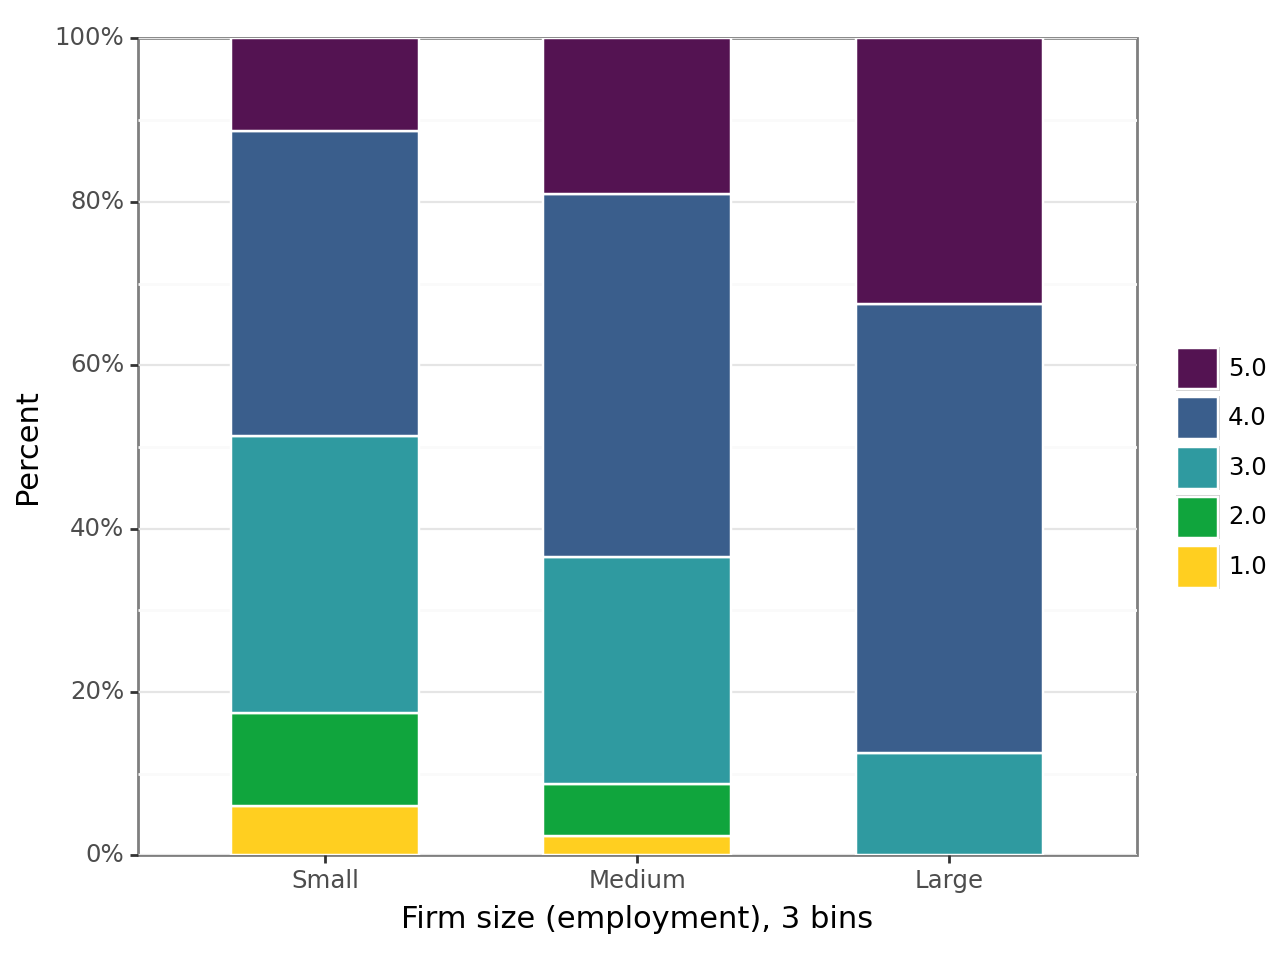

<Figure Size: (640 x 480)>

In [462]:
ggplot(df2, aes(x="emp3bins", y="Percent", fill="perf3")) + geom_bar(
    stat="identity", position="fill", width=0.6, color="white", size=0.5, alpha=0.8
) + scale_y_continuous( 
    expand=(0, 0), limits=(0, 1), breaks=seq(0, 1.1, by=0.2), labels=percent_format()
) + labs(
    x="Firm size (employment), 3 bins", y="Percent"
) + theme_bw() + theme(
    legend_position="right"
) + scale_fill_manual(
    values=(color[2], color[0], color[4], color[1], color[3]), name=" "
) + scale_x_discrete(limits=[1, 2, 3],
                     labels=["Small", "Medium", "Large"])

Now, when it comes to Performance Review, firm size matters in Italy. Smaller firms present a majority of scores between 3 and 4 points. Medium-sized firms showed an increase of 4 and 5 point score. This pattern is even larger among large firms, in which 87% of the companies scored 4 or more points.



<h3>3.6 Ploting bin scatters</h3>
<h4>3.6.1 Three bins</h4>
<p>We can now discuss conditional mean and joint distribution. Remember that <b>joint distribution</b> of two variables is the frequency of each value combination of the two variables. First, let's use the three bins that we had created. We can group them by the 3 bins and the firm sizes. We can get aggregate measures of min, max, average, median, standard deviation, and frequency of each bin category. Then, we will replace the bin numbers by a point corresponding to the midpoint in the employment bin (for instance, 150 for the 100-199 bin, 600 for the 200-999 bin, and so on).</p>

In [463]:
df.filter(["emp_firm", "emp3bins"]).groupby("emp3bins").agg(
    ["min", "max", "mean", "median", np.std, "size"]
)

emp_firm                                               
              min     max         mean  median          std size
emp3bins                                                        
1.0         100.0   193.0   142.295652   140.0    27.537526  115
2.0         200.0   900.0   381.404762   315.0   179.929327  126
3.0        1000.0  4800.0  2162.825000  1500.0  1205.027181   40

In [464]:
# Recode employee bins 
df["emp3bins"] = df["emp3bins"].replace(1, 150).replace(2, 600).replace(3, 3000)

In [465]:
# Summary statistics
df.filter(["emp_firm", "emp3bins"]).groupby("emp3bins").agg(
    ["min", "max", "mean", "median", np.std, "size"]
)

emp_firm                                               
              min     max         mean  median          std size
emp3bins                                                        
150.0       100.0   193.0   142.295652   140.0    27.537526  115
600.0       200.0   900.0   381.404762   315.0   179.929327  126
3000.0     1000.0  4800.0  2162.825000  1500.0  1205.027181   40

<p>We can now get the mean performance scores for each bin by aggregating the data using the 3 bins and visualize the result.</p>

In [466]:
# Generate variables by mean
df1 = df.groupby("emp3bins").agg(performance_emp3bins=("performance", "mean")).reset_index()
df1

,emp3bins,performance_emp3bins
0,150.0,2.949565
1,600.0,3.172928
2,3000.0,3.547500


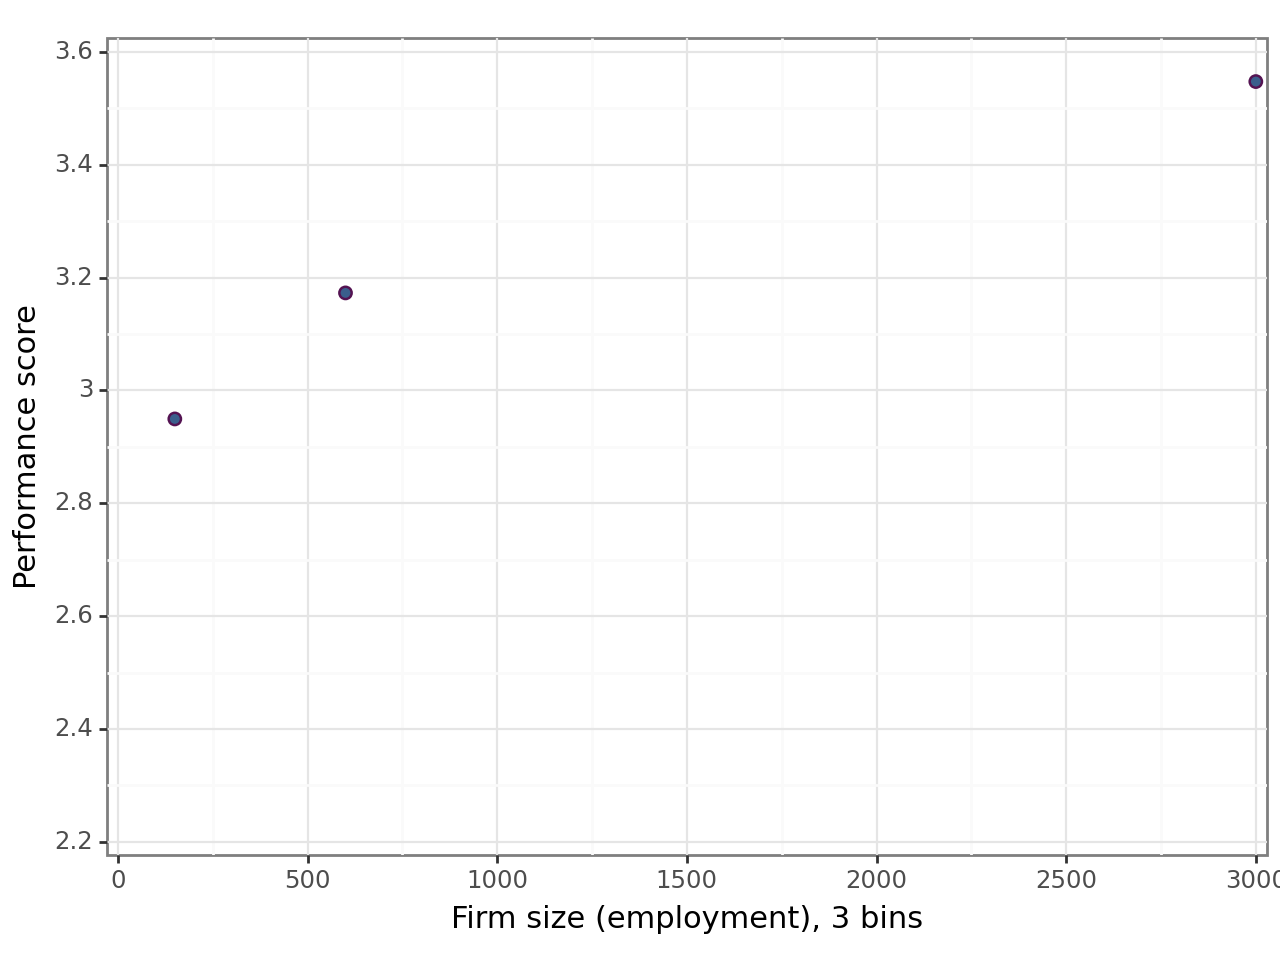

<Figure Size: (640 x 480)>

In [467]:
ggplot(df1, aes(x="emp3bins", y="performance_emp3bins")) + geom_point(
    size=2, color=color[2], fill=color[0], alpha=0.8, na_rm=True
) + scale_y_continuous(
    expand=(0.01, 0.01), limits=(2.2, 3.6), breaks=seq(2.2, 3.8, by=0.2)
) + scale_x_continuous(
    expand=(0.01, 0.01), limits=(0, 3000), breaks=seq(0, 3001, by=500)
) + labs(
    x="Firm size (employment), 3 bins", y="Performance score"
) + theme_bw()

We can observe a positive correlation between the 3 bins and performance score. The mean value for each firm size increases according to firm size. Small firms scored an mean value of **2.94**; medium firms received a mean score value of **3.17**; and larger firms scored a value of **3.54**. 

<p>Now, would this association hold when using a bin scatter of 10 bins? Let's find out.</p>
<h4>3.6.2 Ten-bin scatter</h4>

In [468]:
df["emp10bins"] = pd.qcut(df["emp_firm"],10)

<p>We just applied an interesting function, <code>qcut()</code>, that discretizes variables into equal-sized buckets. I had no idea that such a function existed, so helpful!</p>

In [469]:
# Summary
df_summary = df.filter(["emp_firm", "emp10bins"]).groupby("emp10bins").agg(
    ["min", "max", "mean", "median", np.std, "size"]
)
df_summary

emp_firm                                               
                      min     max         mean  median          std size
emp10bins                                                               
(99.999, 120.0]     100.0   120.0   109.242424   110.0     8.299210   33
(120.0, 140.0]      123.0   140.0   133.250000   130.0     5.225472   28
(140.0, 165.0]      142.0   165.0   153.120000   150.0     6.918092   25
(165.0, 190.0]      170.0   190.0   178.821429   180.0     6.549264   28
(190.0, 240.0]      193.0   240.0   213.392857   205.0    15.900942   28
(240.0, 284.0]      245.0   284.0   257.000000   250.0    11.279662   27
(284.0, 400.0]      290.0   400.0   343.774194   350.0    36.618492   31
(400.0, 600.0]      407.0   600.0   515.518519   500.0    62.211408   27
(600.0, 1300.0]     630.0  1300.0   965.185185   900.0   228.462594   27
(1300.0, 4800.0]   1310.0  4800.0  2637.518519  2000.0  1205.331150   27

<p>We can now get the midpoint of each bin by replacing the interval with the mean of each interval.</p>

In [470]:
# Recode
df = df.replace({"emp10bins": df_summary["emp_firm"]["mean"].to_dict()})

In [471]:
df.filter(["emp_firm", "emp10bins"]).groupby("emp10bins").agg(
    ["min", "max", "mean", "median", np.std, "size"]
)

emp_firm                                               
                        min     max         mean  median          std size
emp10bins                                                                 
109.24242424242425    100.0   120.0   109.242424   110.0     8.299210   33
133.25                123.0   140.0   133.250000   130.0     5.225472   28
153.12                142.0   165.0   153.120000   150.0     6.918092   25
178.82142857142858    170.0   190.0   178.821429   180.0     6.549264   28
213.39285714285714    193.0   240.0   213.392857   205.0    15.900942   28
257.0                 245.0   284.0   257.000000   250.0    11.279662   27
343.7741935483871     290.0   400.0   343.774194   350.0    36.618492   31
515.5185185185185     407.0   600.0   515.518519   500.0    62.211408   27
965.1851851851852     630.0  1300.0   965.185185   900.0   228.462594   27
2637.5185185185187   1310.0  4800.0  2637.518519  2000.0  1205.331150   27

In [472]:
# Return variables by mean
df1 = df.groupby("emp10bins").agg(performance_emp10bins=("performance", "mean")).reset_index()
df1

,emp10bins,performance_emp10bins
0,109.242424,2.742424
1,133.250000,2.792857
2,153.120000,2.984000
3,178.821429,3.317857
4,213.392857,3.142857
5,257.000000,3.040741
6,343.774194,3.144803
7,515.518519,3.225926
8,965.185185,3.451852
9,2637.518519,3.585185


In [473]:
df1 = df1[["emp10bins", "performance_emp10bins"]].astype("float64")

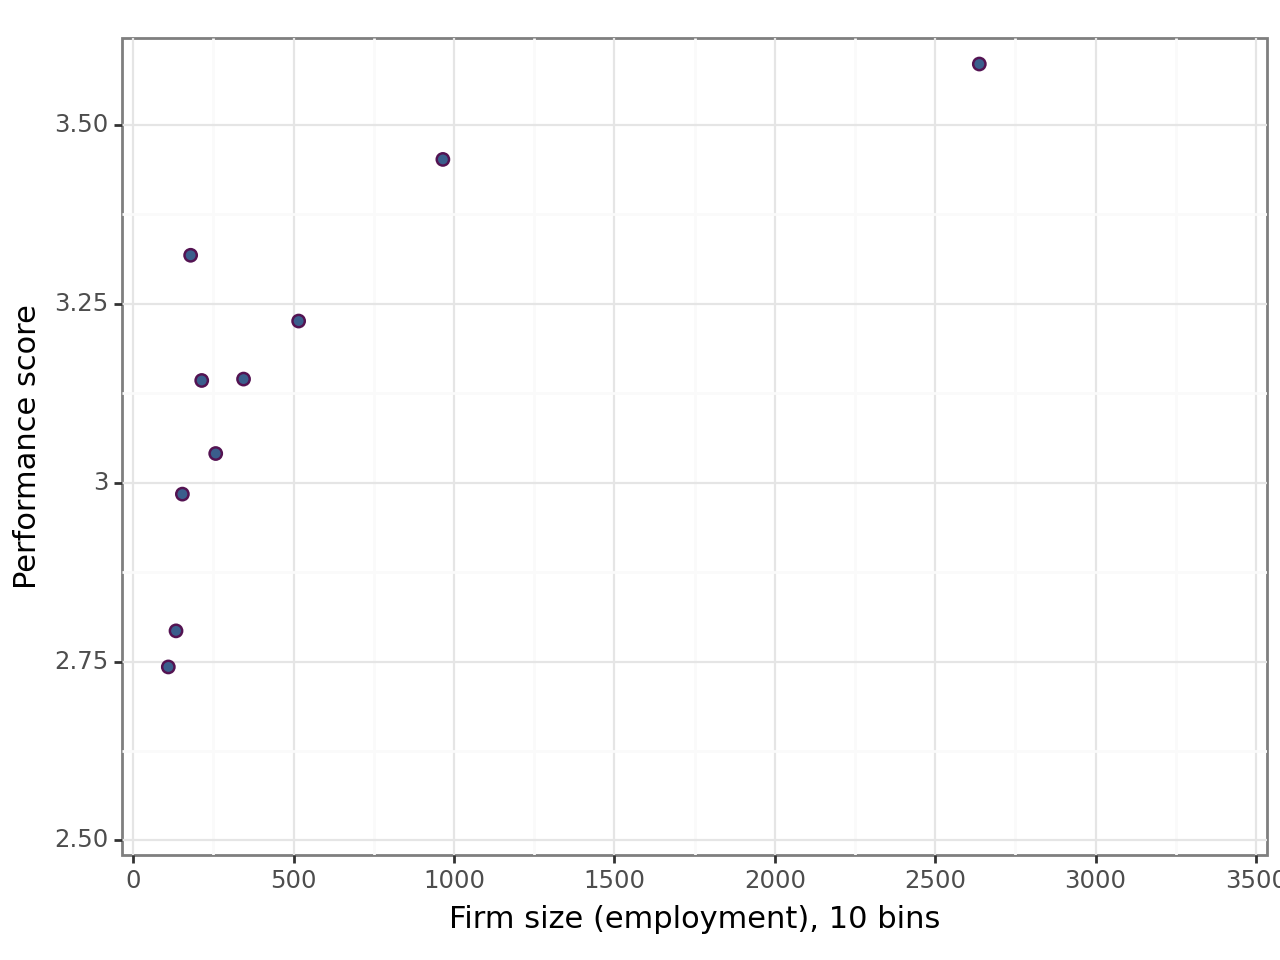

<Figure Size: (640 x 480)>

In [474]:
ggplot(df1, aes(x="emp10bins", y="performance_emp10bins")) + geom_point(
    size=2, color=color[2], fill=color[0], alpha=0.8, na_rm=True
) + scale_y_continuous(
    expand=(0.01, 0.01), limits=(2.5, 3.6), breaks=seq(2.5, 3.8, by=0.25)
) + scale_x_continuous(
    expand=(0.01, 0.01), limits=(0, 3500), breaks=seq(0, 3501, by=500)
) + labs(
    x="Firm size (employment), 10 bins", y="Performance score"
) + theme_bw()

The bin scatter, binned in 10 bins, returned a somewhat **linear relationship**, as the average performance score tended to increase as the firm size increased. It is interesting, though, how small companies quickly increased their scores as the mean firm size increased. Yet, for companies with more between circa 158 and 270 employees, the performance score decreases, only to increase again with larger firms.

<h3>4.3 Scatterplot</h3>

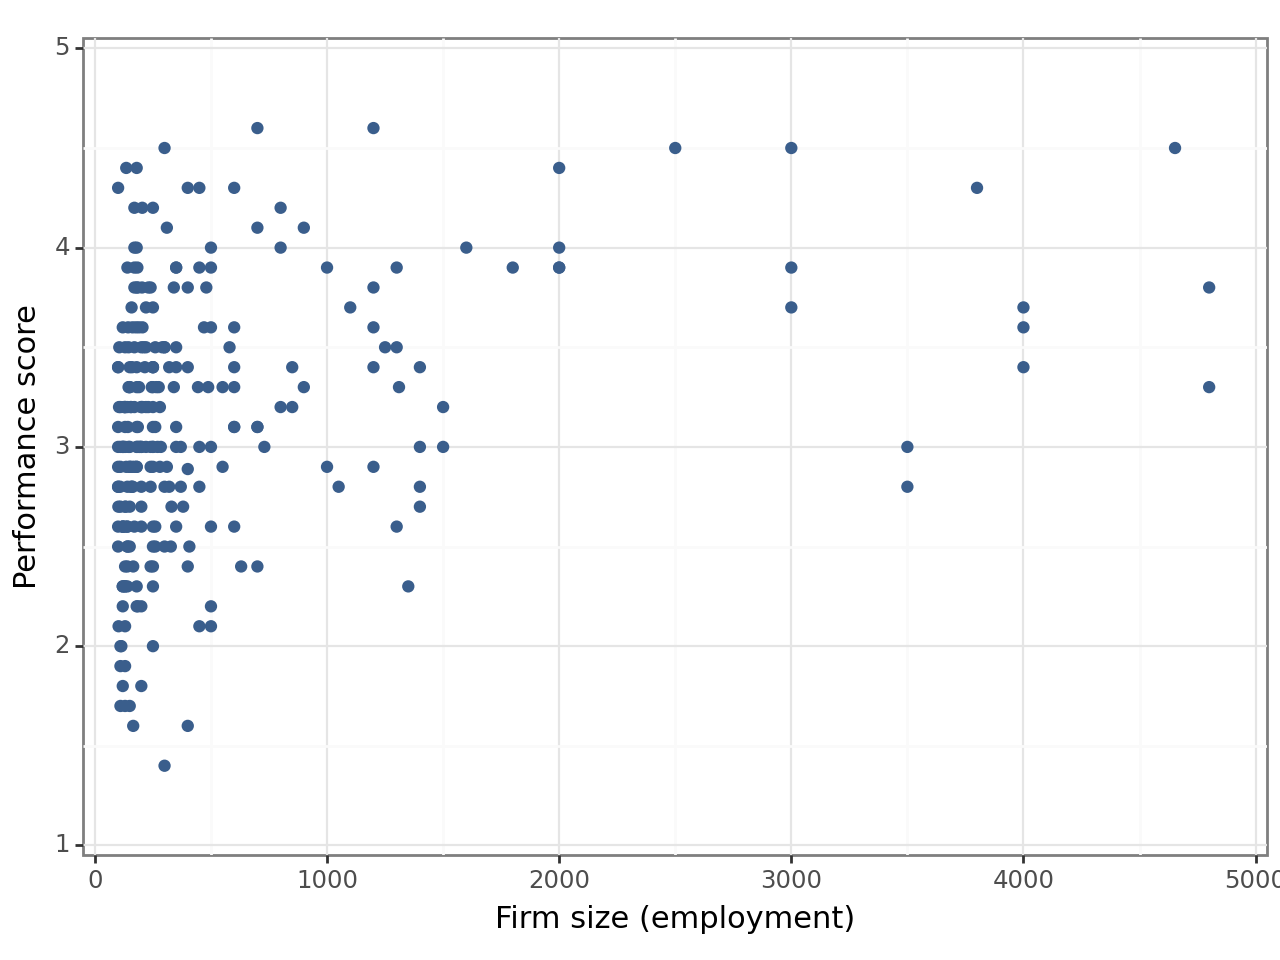

<Figure Size: (640 x 480)>

In [475]:
ggplot(df, aes(x="emp_firm", y="performance")) + geom_point(
    size=1.5, color=color[0], alpha=0.8, na_rm=True
) + scale_y_continuous(
    expand=(0.01, 0.01), limits=(1, 5), breaks=seq(1, 6, 1)
) + scale_x_continuous(
    expand=(0.01, 0.01), limits=(0, 5000), breaks=seq(0, 5001, by=1000)
) + labs(
    x="Firm size (employment)", y="Performance score"
) + theme_bw()

<p>Because the distribution of our data is highly skewed, we cannot see a clear pattern. We can apply the natural log of the employment on the x axis, which translates into a stretched difference between firms at lower levels of employment. Let's observe the results below:</p>

In [476]:
df["lnemp"] = np.log(df["emp_firm"])

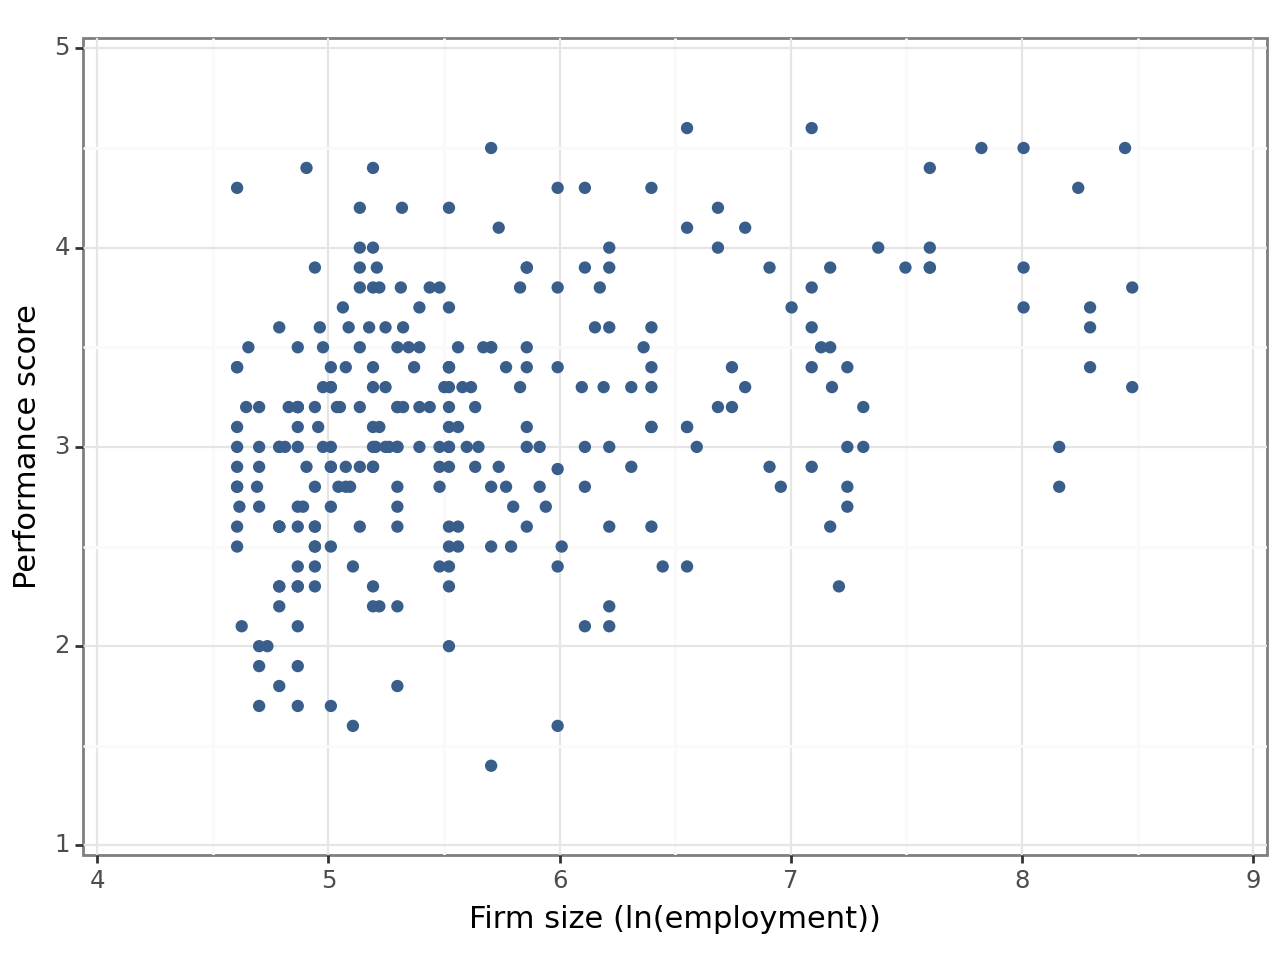

<Figure Size: (640 x 480)>

In [477]:
ggplot(df, aes(x="lnemp", y="performance")) + geom_point(
    size=1.5, color=color[0], alpha=0.8, na_rm=True
) + scale_y_continuous(
    expand=(0.01, 0.01), limits=(1, 5), breaks=seq(1, 6, 1)
) + scale_x_continuous(
    expand=(0.01, 0.01), limits=(4, 9), breaks=seq(4, 10, by=1)
) + labs(
    x="Firm size (ln(employment))", y="Performance score"
) + theme_bw()

<p>With our observations spread out, we can observe a positive correlation between management score and firm size. However, we also see a lot of variation of the management score at every level of employment - there is a lot of spread of the management score among firms with the same size.</p>
<p>To get more insight into whether - and to what extent - the spread or skewness of the performance score distribution differ at different levels of employments, we can produce <b>box plots</b> and <b>violin plots</b> of the performance score for three employment bins.</p>
<h3>3.7 Box plots and violin plots to visualize the spread of the data</h3>
<h4>3.7.1 Box plot</h4>

In [478]:
df = df.replace({"emp3bins":{
                    150: "Small",
                    600: "Medium",
                    3000: "Large",}
                    })

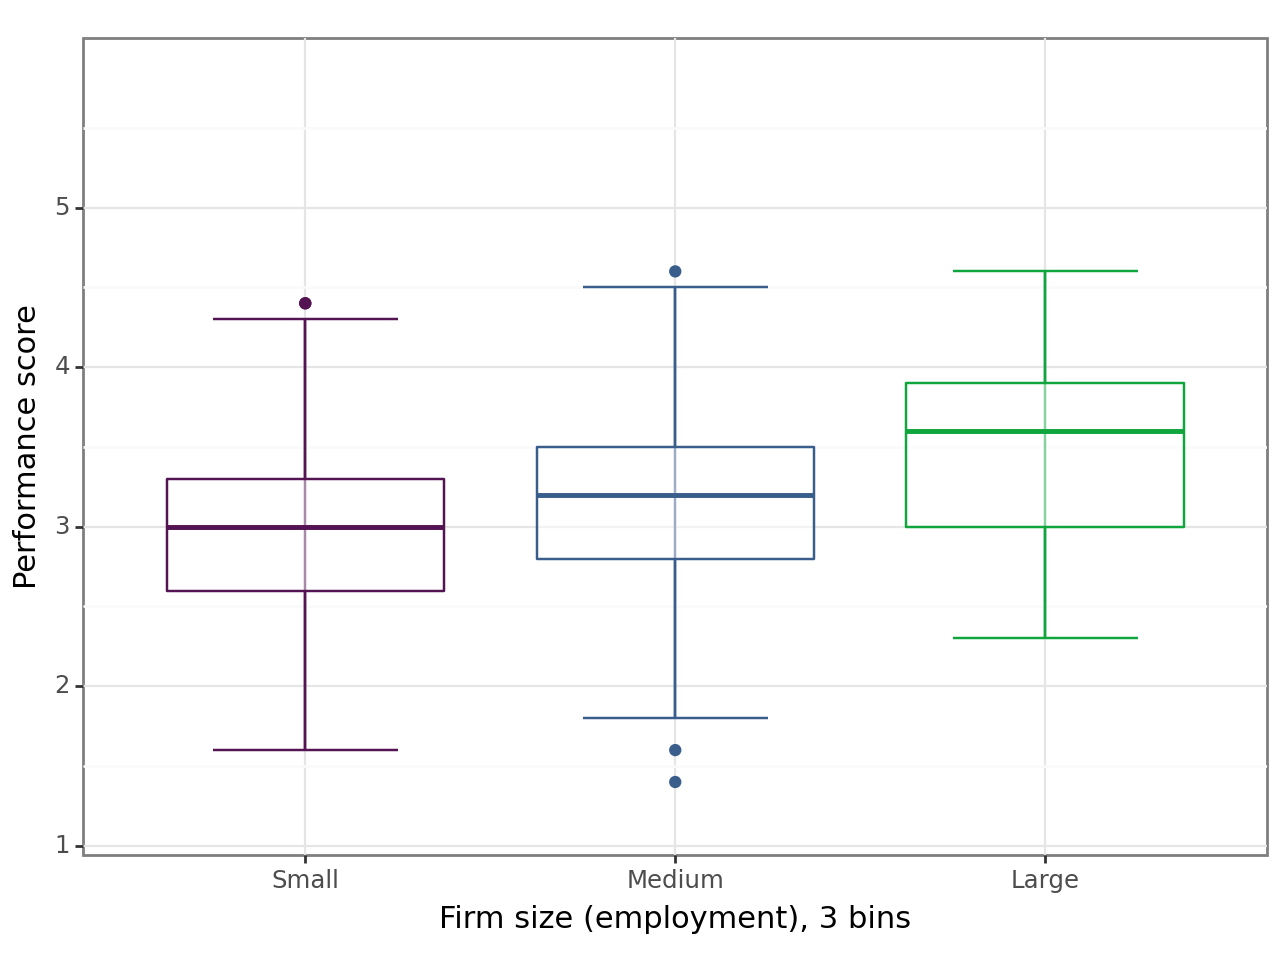

<Figure Size: (640 x 480)>

In [479]:
# Bot plots
ggplot(df, aes(x="pd.Categorical(df['emp3bins'], categories=sorted(set(df['emp3bins']), reverse=True))",
               y="performance",
               ),
    ) + stat_boxplot(
        aes(group="emp3bins"),
        geom="errorbar",
        width=0.5,
        color=(color[1], color[0], color[2]),
        size=0.5,
        na_rm=True,
    ) + geom_boxplot(
        aes(group="emp3bins"),
        color=(color[2], color[0], color[1]),
        size=0.5,
        alpha=0.5,
        na_rm=True,
    ) + labs(
        x="Firm size (employment), 3 bins",
        y="Performance score"
    ) + scale_y_continuous(
        expand=(0.01, 0.01), limits=(1, 6), breaks=seq(1, 6, 1)
    ) + theme_bw()

<h4>3.7.2 Violin plots </h4>

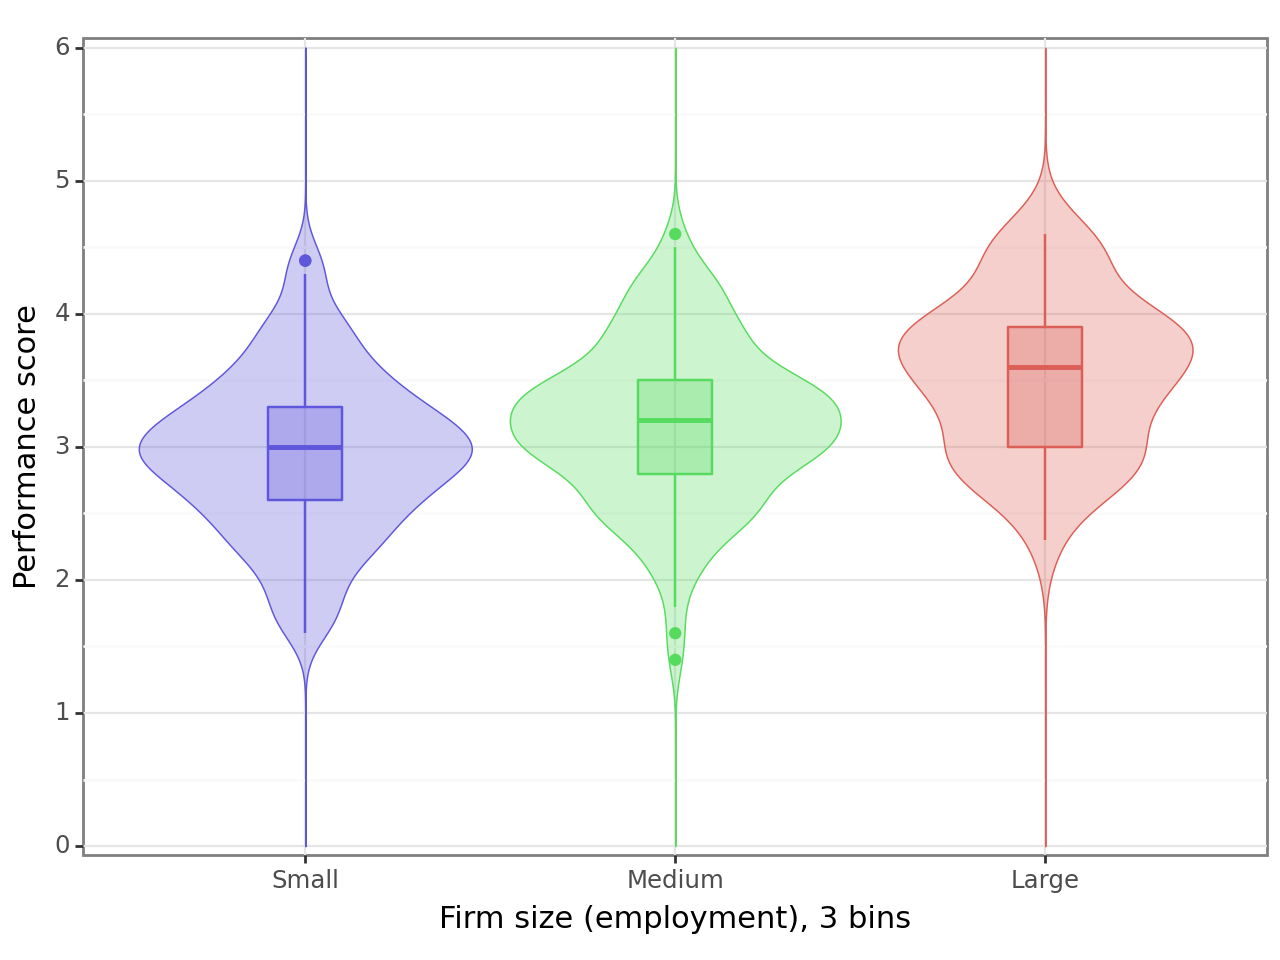

<Figure Size: (640 x 480)>

In [480]:
ggplot(df, 
       aes(x="pd.Categorical(df['emp3bins'], categories=sorted(set(df['emp3bins']), reverse=True))",
           y="performance",
           color="emp3bins",
           fill="emp3bins",    
               ),
    ) + geom_violin(
        aes(group="emp3bins"),
        alpha=0.3,
        size=0.3,
        trim=False,
        show_legend=False,
        na_rm=True,
    ) + geom_boxplot(
        aes(group="emp3bins"),
        size=0.5,
        alpha=0.3,
        width=0.2,
        na_rm=True,
    ) + labs(
        x="Firm size (employment), 3 bins",
        y="Performance score"
    ) + scale_y_continuous(
        expand=(0.01, 0.01), limits=(0, 6), breaks=seq(0, 7, 1)
    ) + guides(
        fill=False, color=False
    ) + theme_bw()

Violin plots are useful for visualizing the density of our data distribution. We can see how larger firms present actually a sparser distribution of data. There is a higher concentration around the median, which is closer to the top of the box, indicating a degree of skewness. Yet, there is also a significant concentration around the lower part of the box, which is around a performance score of 3. As such, differently han small and medium companies, we can affirm that although larger Italian companies perform better than small and mid-size firms, we get to see a significant variability between them.

<h3>3.8 Correlation and latent variable</h3>
<p>A <b>latent variable</b> is an abstract variable, which is not a part of the dataset by itself, as it cannot be directly measured. Instead, we use <b>proxy variables</b>, which indeed replace them as a way to measure its original variables.</p>
<p>

In [481]:
# get the covariance between firm size and management score
covariance = round(df["emp_firm"].cov(df["performance"]),2)

In [482]:
df_results = pd.DataFrame(
    data={"covariance": covariance,
     "firm_size_std": df["emp_firm"].std(),
     "performance_score_std": df["performance"].std(),
     "corr_coef": df["emp_firm"].corr(df["performance"])},
     index=[0]
)
df_results

,covariance,firm_size_std,performance_score_std,corr_coef
0,160.94,818.237523,0.630996,0.311711


<p>As we can see, the covariance between firm size and the performance score is <b>206</b>. The standard deviation for both variables is <b>818.23</b> and <b>0.63</b>, respectively. The correlation coefficient is <b>0.31</b>. This outcome hints at a <b>positive</b> association, whereas firms with more employees tend to have higher performance. Such magnitude, however, is <b>moderate</b>, as other factors may impinge on performance score in addition to the size of a company.</p>
<p>We can analyze the correlation coefficient in seven broad categories of industrial classification (in addition to one "other" category with the industry with very few firms, combined).</p>

In [483]:
# Correlation by industry
df["industry_broad"] = np.NaN
df.loc[df["sic"] <= 21, "industry_broad"] = "foods_drink_tobacco"
df.loc[
    ((df["sic"] >= 22) & (df["sic"] <= 23)) | (df["sic"] == 31), "industry_broad" 
] = "textile_apparel_leather_etc"
df.loc[(df["sic"] >= 24) & (df["sic"] <= 27), "industry_broad"] = "wood_furniture_paper"
df.loc[(df["sic"] >= 28) & (df["sic"] <= 30), "industry_broad"] = "chemicals_etc"
df.loc[(df["sic"] >= 32) & (df["sic"] < 35), "industry_broad"] = "materials_metals"
df.loc[(df["sic"] >= 35) & (df["sic"] <= 37), "industry_broad"] = "electronics"
df.loc[(df["sic"] == 37) , "industry_broad"] = "auto"
df.loc[(df["sic"] >= 38) , "industry_broad"] = "other"

In [484]:
df["industry_broad"].value_counts()

industry_broad
materials_metals               78
electronics                    63
chemicals_etc                  55
wood_furniture_paper           33
textile_apparel_leather_etc    15
foods_drink_tobacco            14
auto                           12
other                          11
Name: count, dtype: int64

In [485]:
# Check correlation
df.groupby("industry_broad")[["performance", "emp_firm"]].corr().iloc[0::2, -1]

industry_broad                          
auto                         performance    0.610705
chemicals_etc                performance    0.503504
electronics                  performance    0.256966
foods_drink_tobacco          performance    0.757351
materials_metals             performance    0.138766
other                        performance    0.650400
textile_apparel_leather_etc  performance    0.471340
wood_furniture_paper         performance    0.119777
Name: emp_firm, dtype: float64

We can see that, among Italian firms, the correlation coefficient <b>varies a lot</b>. For sectors such as auto, chemicals, food, drinks and tobacco, and others, this coefficient is higher than 0.31; food, drink, and tobacco industries registered a coefficient of <b>0.75</b>. In sectors particularly related to raw materials, such as wood and metals, the value drops to levels at around 0.10, showing a <b>very weak correlation</b>.

In [486]:
df.filter(["performance", "industry_broad"]).loc[
    lambda x: ~x["industry_broad"].isnull()
].groupby("industry_broad").agg(
    Min=("performance", min),
    Max=("performance", max),
    SD=("performance", np.std),
    Median=("performance", "median"),
    n=("performance", "size")
)

,Min,Max,SD,Median,n
industry_broad,,,,,
auto,2.0,4.6,0.847814,3.45,12
chemicals_etc,1.7,4.6,0.622269,3.20,55
electronics,1.8,4.5,0.587038,3.20,63
foods_drink_tobacco,2.5,4.3,0.528579,3.10,14
materials_metals,1.6,4.5,0.611025,3.10,78
other,2.5,4.3,0.556940,3.30,11
textile_apparel_leather_etc,1.9,3.8,0.566527,2.80,15
wood_furniture_paper,1.4,4.4,0.720296,2.90,33


We can also notice the difference in sample sizes for each industry and how it may affect the performance scores. For instance, sectors that showed a high coefficient also present the lowest number of observations, while areas in which this value was very low, the number of observations was significantly higher.

In [487]:
# Check correlation
cor = (
    pd.DataFrame(
        df.groupby("industry_broad")[["performance", "emp_firm"]].corr().iloc[0::2, -1]
    )
    .reset_index()
    .drop(["level_1"], axis=1)
)

In [488]:
cor.columns = ["industry_broad", "COR"]
cor = cor.set_index("industry_broad")

In [489]:
table_final = (
    df.filter(["emp_firm", "industry_broad", "performance"])
    .groupby("industry_broad")
    .agg(Mean=("performance", "mean"), Obs=("performance", "size"))
)

table_final["cor"] = cor["COR"]

In [490]:
table_final.index = [
    "Auto",
    "Chemicals",
    "Machinery, equipment, electroncis",
    "Food, drinks, tobacco",
    "Materials, metals",
    "Textile, apparel, leather",
    "Wood, furniture, paper",
    "Other",
]
table_final.round(2)

,Mean,Obs,cor
Auto,3.33,12,0.61
Chemicals,3.24,55,0.50
"Machinery, equipment, electroncis",3.19,63,0.26
"Food, drinks, tobacco",3.16,14,0.76
"Materials, metals",3.09,78,0.14
"Textile, apparel, leather",3.37,11,0.65
"Wood, furniture, paper",2.87,15,0.47
Other,2.92,33,0.12


In [491]:
last_row = (
    table_final.groupby(lambda _: True)
    .agg(Mean=("Mean", "mean"), Obs=("Obs", "sum"), cor=("cor", "mean"))
    .reset_index(drop=True)
)

last_row.index = ["All"]

In [492]:
table_final

,Mean,Obs,cor
Auto,3.333333,12,0.610705
Chemicals,3.238182,55,0.503504
"Machinery, equipment, electroncis",3.192063,63,0.256966
"Food, drinks, tobacco",3.164286,14,0.757351
"Materials, metals",3.090883,78,0.138766
"Textile, apparel, leather",3.372727,11,0.650400
"Wood, furniture, paper",2.866667,15,0.471340
Other,2.915152,33,0.119777


In [493]:
last_row

,Mean,Obs,cor
All,3.146662,281,0.438601


In [494]:
table_final = pd.concat([table_final, last_row])

In [495]:
table_final = table_final.loc[:, ["cor", "Mean", "Obs"]].reset_index()
table_final.columns = [
    "Industry",
    "Performance - employment correlation",
    "Performance score",
    "Observations",
]

In [496]:
table_final.round(2)

,Industry,Performance - employment correlation,Performance score,Observations
0,Auto,0.61,3.33,12
1,Chemicals,0.50,3.24,55
2,"Machinery, equipment, electroncis",0.26,3.19,63
3,"Food, drinks, tobacco",0.76,3.16,14
4,"Materials, metals",0.14,3.09,78
5,"Textile, apparel, leather",0.65,3.37,11
6,"Wood, furniture, paper",0.47,2.87,15
7,Other,0.12,2.92,33
8,All,0.44,3.15,281


<h2>5. Conclusion</h2>
<p>What did we learn about the association between firm size and performance quality among Italian firms?</p>
<ul>
<li>Among Italian manufacturing firms, <b>larger</b> firms <m>tend</m> to be better managed, but that can vary dependening on the <b>industry</b>.</li>
<ul>
<li>Large firms have an average score of <b>3.54</b>, compared to <b>3.17</b> for medium-sized firms, and <b>2.94</b> for small ones.</li>
</ul>
<li>The correlation, even though positive, is <b>not very strong</b>. Maybe other issues also affect the quality of management besides firm size.</li>
<li>When disaggregating the results into smaller industry groups, we found that the strength of the management-size correlation differs in some industries from the rest, although we have not observed any pattern that would tell us why.</li>
</ul>
<p>With these final statements, we conclude our data exercise. We could definetely observe a positive yet mild correlation between firm size and performance score. Still, the high degree of variability showed that just the number of employees is not enough to explain good (or bad) performance scores!</p>
<p>Thank you for reading!</p>
<hr>